# Notebook 2: Tree-Based Ensembles

In this notebook, we test tree-based algorithms using the original train/valid/test split. When possible, we try to leave the settings as default, in some cases we tweak the settings so that similar models have similar settings (e.g. sklearn/XGBoost/LightGBM random forests). 

These benchmarks are not definitive, hyperparameter tweaking and feature engineering could cause different models to perform better/worse, these are just baselines so we can narrow our searches.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12

In [2]:
import numpy as np
import pandas as pd
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load and Prepare Data

In [3]:
def categorical_encoding(data):
    df = data.copy()
    df['Soil_Type'] = 0
    soil_features = list()
    for i in range(1,41):
        df['Soil_Type'] += i*df[f'Soil_Type{i}']
        soil_features.append(f'Soil_Type{i}')
    nonsoil_features = [x for x in df.columns if x not in soil_features]
    return df[nonsoil_features]

In [4]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [5]:
%%time
original = get_data()

# Get feature columns
original = categorical_encoding(original)
features = [x for x in original.columns if x not in ['Id','Cover_Type']]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
metrics = list()

Wall time: 222 ms


# Scoring Function

In [6]:
def train_original(sklearn_model, plot = True):
    
    # Original Training/Test Split
    X_temp = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_temp = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    labels = label_binarize(y_temp, classes = sorted(np.unique(y_temp)))

    
    # Store the out-of-fold predictions
    test_proba = np.zeros((X_test.shape[0],7))
    train_proba = np.zeros((X_temp.shape[0],7))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_temp,y_temp)):
       
        # Training and Validation Sets
        X_train = X_temp.iloc[train_idx]
        X_valid = X_temp.iloc[valid_idx]
        y_train = y_temp.iloc[train_idx]
        y_valid = y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)

        try:
            # model supports predict_proba
            valid_proba = model.predict_proba(X_valid)
            test_proba += model.predict_proba(X_test)
        except:
            # model does not support predict proba
            valid_proba = softmax(model.decision_function(X_valid))
            test_proba += softmax(model.decision_function(X_test))
        
        # validation preds
        train_proba[valid_idx,:] = valid_proba
        valid_preds = np.argmax(valid_proba, axis = 1)
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold}: {round(100 * fold_acc, 3)}% Accuracy in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        time.sleep(0.5)
    
    train_preds = np.argmax(train_proba, axis = 1)
    train_auc = roc_auc_score(labels, train_proba, multi_class = 'ovo')
    train_f1 = f1_score(y_temp, train_preds, average = 'macro')
    test_preds = np.argmax(test_proba, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    print("\nMean Acc (CV):", 100 * round(scores.mean(), 5))
    print("ROC AUC  (CV):", round(train_auc, 5))
    print("F1 Score (CV):", round(train_f1, 5))
    print('Submission   :', round(holdout, 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    if plot:
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize = (8,6))
        cm = confusion_matrix(y_test, test_preds, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax = ax)
        plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
        plt.xlabel("Predicted Labels", fontsize=14)
        plt.ylabel("Actual Labels", fontsize=14)
        plt.show()
    
    return scores.mean(), test_preds, holdout

# Scikit-Learn Models

We test the following models from the scikit-learn library:

1. AdaBoost
2. ExtraTrees
3. Bagging
4. RandomForest
5. GradientBoosting
6. HistGradientBoosting

## 1. AdaBoostClassifier

In [7]:
# AdaBoost Classifier
adaboost_pipeline = make_pipeline(
    AdaBoostClassifier(
        # Same settings as ExtraTreesClassifier
        base_estimator = DecisionTreeClassifier(
            splitter = 'random',
            random_state = RANDOM_SEED,
        ),
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 80.0% Accuracy in 0.32s.
Fold 1: 81.032% Accuracy in 0.31s.
Fold 2: 78.095% Accuracy in 0.33s.
Fold 3: 78.016% Accuracy in 0.28s.
Fold 4: 77.302% Accuracy in 0.27s.
Fold 5: 76.032% Accuracy in 0.28s.
Fold 6: 78.016% Accuracy in 0.28s.
Fold 7: 78.968% Accuracy in 0.32s.
Fold 8: 77.937% Accuracy in 0.29s.
Fold 9: 80.714% Accuracy in 0.28s.
Fold 10: 78.413% Accuracy in 0.3s.
Fold 11: 78.634% Accuracy in 0.28s.

Mean Acc (CV): 78.596
ROC AUC  (CV): 0.87514
F1 Score (CV): 0.78531
Submission   : 0.76229
Training Time: 3.53s



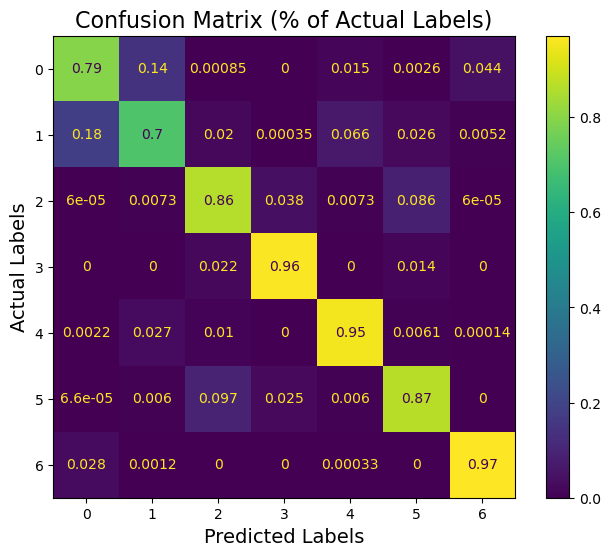

In [8]:
test_score, oof_preds, holdout = train_original(adaboost_pipeline)

metrics.append((
    'AdaBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. ExtraTrees

In [9]:
# ExtraTrees Classifier
extratrees_pipeline = make_pipeline(
    ExtraTreesClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
        max_features = None,
    ),
)

Fold 0: 88.968% Accuracy in 3.01s.
Fold 1: 88.175% Accuracy in 2.98s.
Fold 2: 88.571% Accuracy in 3.14s.
Fold 3: 89.127% Accuracy in 3.27s.
Fold 4: 88.968% Accuracy in 3.27s.
Fold 5: 88.492% Accuracy in 3.48s.
Fold 6: 88.095% Accuracy in 3.19s.
Fold 7: 87.222% Accuracy in 3.68s.
Fold 8: 86.349% Accuracy in 3.12s.
Fold 9: 89.286% Accuracy in 2.92s.
Fold 10: 88.968% Accuracy in 3.51s.
Fold 11: 90.23% Accuracy in 3.86s.

Mean Acc (CV): 88.538
ROC AUC  (CV): 0.98816
F1 Score (CV): 0.88407
Submission   : 0.78206
Training Time: 39.44s



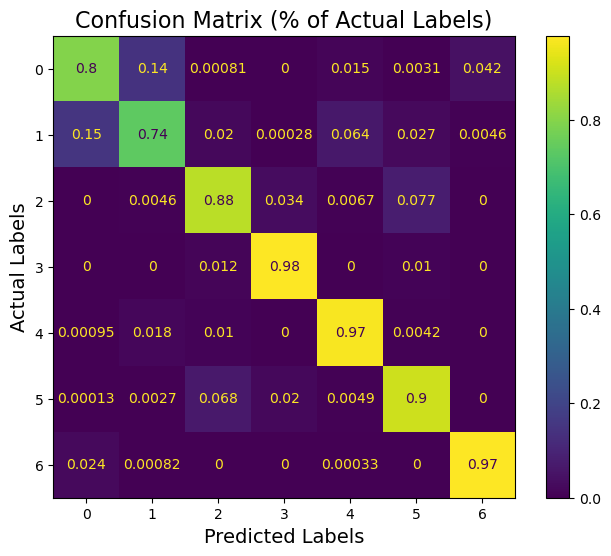

In [10]:
test_score, oof_preds, holdout = train_original(extratrees_pipeline)

metrics.append((
    'ExtraTrees', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. BaggingClassifier

In [11]:
# Bagging Classifier
bagging_pipeline = make_pipeline(
    BaggingClassifier(
        base_estimator = DecisionTreeClassifier(
            splitter = 'random',
            random_state = RANDOM_SEED,
        ),
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 84.841% Accuracy in 4.67s.
Fold 1: 84.206% Accuracy in 1.71s.
Fold 2: 84.127% Accuracy in 1.72s.
Fold 3: 84.603% Accuracy in 1.75s.
Fold 4: 85.317% Accuracy in 1.68s.
Fold 5: 85.635% Accuracy in 1.82s.
Fold 6: 85.159% Accuracy in 1.73s.
Fold 7: 84.365% Accuracy in 1.72s.
Fold 8: 84.683% Accuracy in 2.0s.
Fold 9: 84.444% Accuracy in 2.15s.
Fold 10: 86.746% Accuracy in 1.94s.
Fold 11: 85.941% Accuracy in 2.19s.

Mean Acc (CV): 85.006
ROC AUC  (CV): 0.97736
F1 Score (CV): 0.84855
Submission   : 0.75982
Training Time: 25.07s



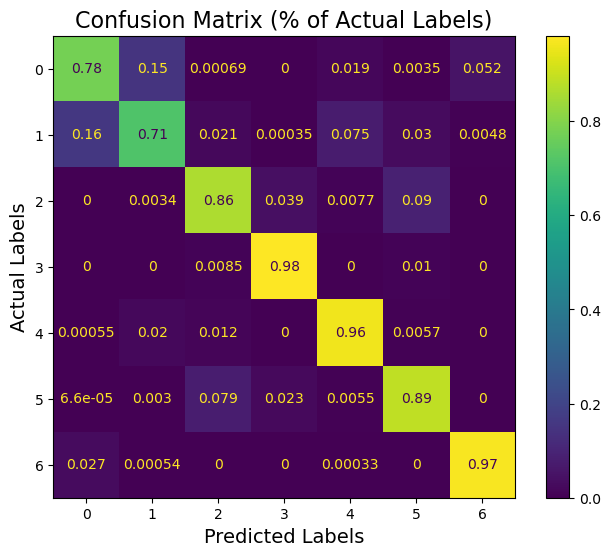

In [12]:
test_score, oof_preds, holdout = train_original(bagging_pipeline)

metrics.append((
    'Bagging', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. RandomForest

In [13]:
# Random Forest Classifier
randomforest_pipeline = make_pipeline(
    RandomForestClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 87.302% Accuracy in 3.64s.
Fold 1: 85.873% Accuracy in 3.62s.
Fold 2: 86.429% Accuracy in 3.21s.
Fold 3: 86.746% Accuracy in 3.18s.
Fold 4: 86.746% Accuracy in 3.61s.
Fold 5: 86.587% Accuracy in 4.11s.
Fold 6: 86.667% Accuracy in 3.44s.
Fold 7: 85.556% Accuracy in 3.12s.
Fold 8: 85.159% Accuracy in 3.18s.
Fold 9: 86.825% Accuracy in 3.14s.
Fold 10: 86.27% Accuracy in 3.19s.
Fold 11: 87.292% Accuracy in 3.68s.

Mean Acc (CV): 86.454
ROC AUC  (CV): 0.98499
F1 Score (CV): 0.86248
Submission   : 0.74822
Training Time: 41.11s



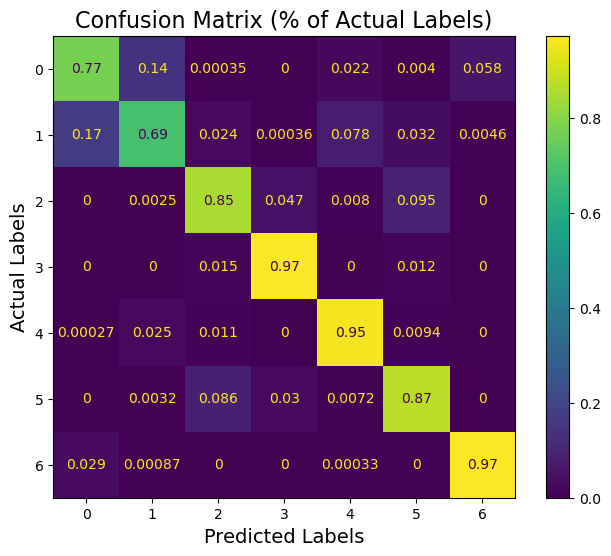

In [14]:
test_score, oof_preds, holdout = train_original(randomforest_pipeline)

metrics.append((
    'RandomForest', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. GradientBoosting

In [15]:
# Gradient Boosting Classifier
gbc_pipeline = make_pipeline(
    GradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 79.444% Accuracy in 21.25s.
Fold 1: 78.413% Accuracy in 19.73s.
Fold 2: 79.048% Accuracy in 20.83s.
Fold 3: 79.048% Accuracy in 19.25s.
Fold 4: 81.19% Accuracy in 18.73s.
Fold 5: 79.206% Accuracy in 18.34s.
Fold 6: 80.238% Accuracy in 20.01s.
Fold 7: 79.524% Accuracy in 19.47s.
Fold 8: 79.365% Accuracy in 19.92s.
Fold 9: 80.159% Accuracy in 20.89s.
Fold 10: 80.635% Accuracy in 20.72s.
Fold 11: 80.143% Accuracy in 20.76s.

Mean Acc (CV): 79.701
ROC AUC  (CV): 0.97076
F1 Score (CV): 0.79329
Submission   : 0.65137
Training Time: 239.91s



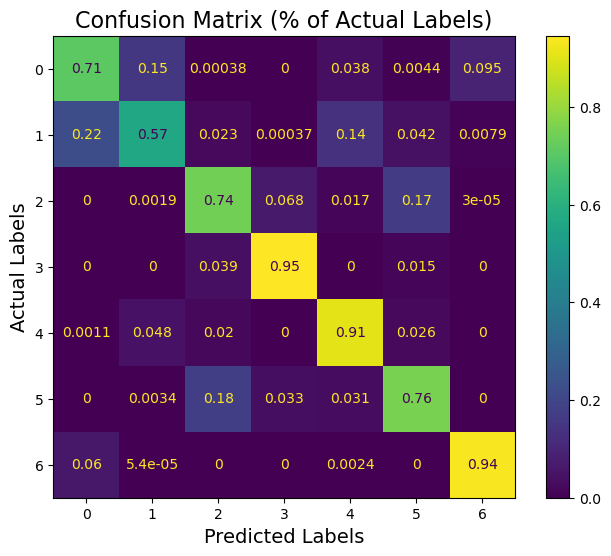

In [16]:
test_score, oof_preds, holdout = train_original(gbc_pipeline)

metrics.append((
    'GradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. HistGradientBoosting

In [17]:
# Gradient Boosting Classifier
hgbc_pipeline = make_pipeline(
    HistGradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 85.714% Accuracy in 9.45s.
Fold 1: 85.794% Accuracy in 9.59s.
Fold 2: 85.714% Accuracy in 10.69s.
Fold 3: 86.111% Accuracy in 10.68s.
Fold 4: 86.667% Accuracy in 9.93s.
Fold 5: 85.238% Accuracy in 10.5s.
Fold 6: 85.0% Accuracy in 10.1s.
Fold 7: 85.556% Accuracy in 10.07s.
Fold 8: 85.714% Accuracy in 10.05s.
Fold 9: 86.349% Accuracy in 10.63s.
Fold 10: 85.397% Accuracy in 11.16s.
Fold 11: 86.18% Accuracy in 10.21s.

Mean Acc (CV): 85.786
ROC AUC  (CV): 0.98373
F1 Score (CV): 0.85584
Submission   : 0.74048
Training Time: 123.06s



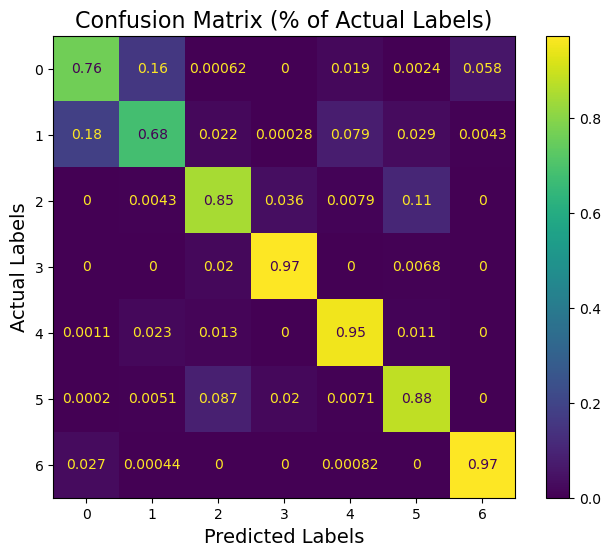

In [18]:
test_score, oof_preds, holdout = train_original(hgbc_pipeline)

metrics.append((
    'HistGradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# XGBoost

We test out several XGBoost models:

1. Vanilla
2. Random Forest
3. DART

## 1. XGBoost Baseline

In [19]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 85.952% Accuracy in 2.55s.
Fold 1: 84.841% Accuracy in 2.55s.
Fold 2: 85.714% Accuracy in 2.49s.
Fold 3: 86.508% Accuracy in 2.52s.
Fold 4: 86.587% Accuracy in 2.53s.
Fold 5: 84.524% Accuracy in 2.8s.
Fold 6: 85.0% Accuracy in 2.8s.
Fold 7: 84.841% Accuracy in 2.67s.
Fold 8: 86.349% Accuracy in 2.72s.
Fold 9: 86.667% Accuracy in 2.6s.
Fold 10: 86.667% Accuracy in 2.48s.
Fold 11: 86.815% Accuracy in 2.44s.

Mean Acc (CV): 85.872
ROC AUC  (CV): 0.9838
F1 Score (CV): 0.85658
Submission   : 0.74108
Training Time: 31.16s



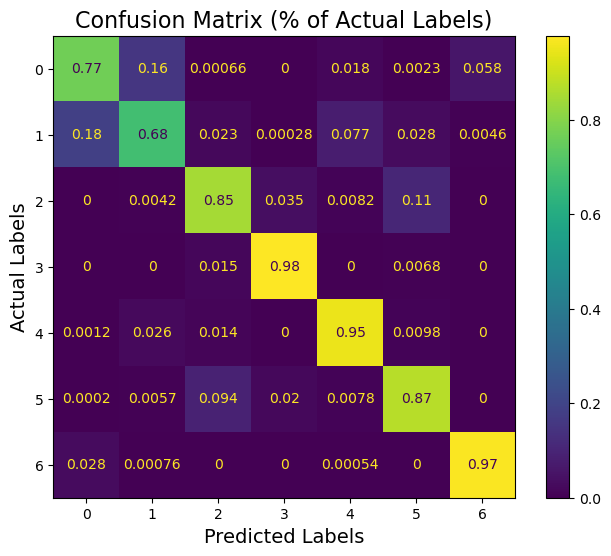

In [20]:
test_score, oof_preds, holdout = train_original(xgb_pipeline)

metrics.append((
    'XGBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. XGBoost (Random Forest)

In [21]:
# XGBoost Classifier
xgbrf_pipeline = make_pipeline(
    XGBRFClassifier(
        eval_metric = 'mlogloss',
        num_parallel_tree = 100,
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 77.46% Accuracy in 3.21s.
Fold 1: 74.444% Accuracy in 3.35s.
Fold 2: 76.746% Accuracy in 3.55s.
Fold 3: 75.397% Accuracy in 3.19s.
Fold 4: 76.984% Accuracy in 3.5s.
Fold 5: 75.079% Accuracy in 3.18s.
Fold 6: 76.349% Accuracy in 3.26s.
Fold 7: 75.317% Accuracy in 3.52s.
Fold 8: 76.27% Accuracy in 3.16s.
Fold 9: 77.381% Accuracy in 3.43s.
Fold 10: 76.587% Accuracy in 3.43s.
Fold 11: 75.616% Accuracy in 3.15s.

Mean Acc (CV): 76.13600000000001
ROC AUC  (CV): 0.9597
F1 Score (CV): 0.75325
Submission   : 0.58261
Training Time: 39.95s



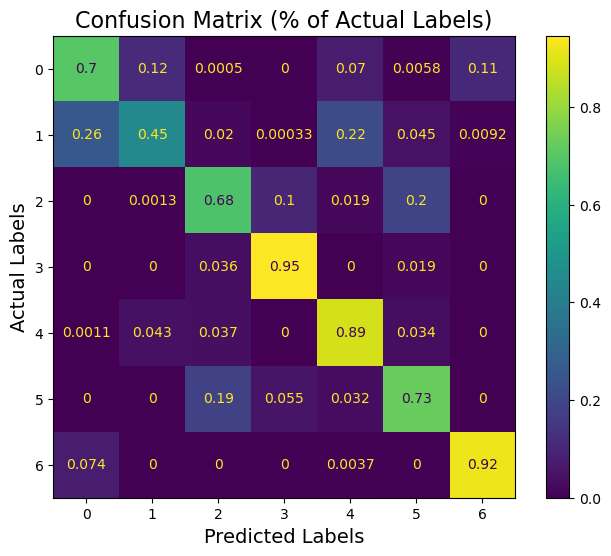

In [22]:
test_score, oof_preds, holdout = train_original(xgbrf_pipeline)

metrics.append((
    'XGBoost_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. XGBoost (DART)

In [23]:
# XGBoost Classifier
xgbdart_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'dart',
        eval_metric = 'mlogloss',
        rate_drop = 0.1,
        skip_drop = 0.5,
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 85.0% Accuracy in 38.62s.
Fold 1: 84.603% Accuracy in 35.57s.
Fold 2: 83.571% Accuracy in 38.94s.
Fold 3: 84.841% Accuracy in 36.12s.
Fold 4: 85.476% Accuracy in 39.17s.
Fold 5: 83.889% Accuracy in 39.64s.
Fold 6: 84.524% Accuracy in 42.8s.
Fold 7: 84.762% Accuracy in 37.27s.
Fold 8: 85.159% Accuracy in 34.68s.
Fold 9: 85.238% Accuracy in 36.52s.
Fold 10: 84.841% Accuracy in 36.05s.
Fold 11: 85.465% Accuracy in 38.44s.

Mean Acc (CV): 84.78099999999999
ROC AUC  (CV): 0.98198
F1 Score (CV): 0.84534
Submission   : 0.72389
Training Time: 453.82s



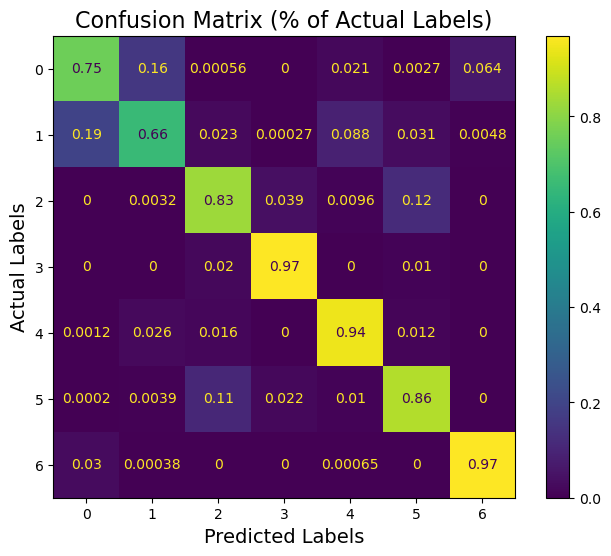

In [24]:
test_score, oof_preds, holdout = train_original(xgbdart_pipeline)

metrics.append((
    'XGBoost_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LightGBM

1. Vanilla
2. Random Forest
3. DART
4. GOSS

## 1. LightGBM (Baseline)

In [25]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'gbdt',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 85.635% Accuracy in 3.57s.
Fold 1: 85.0% Accuracy in 3.04s.
Fold 2: 85.159% Accuracy in 2.91s.
Fold 3: 86.19% Accuracy in 3.28s.
Fold 4: 87.063% Accuracy in 3.35s.
Fold 5: 85.635% Accuracy in 3.4s.
Fold 6: 85.476% Accuracy in 3.02s.
Fold 7: 85.397% Accuracy in 2.96s.
Fold 8: 85.317% Accuracy in 3.11s.
Fold 9: 86.27% Accuracy in 2.91s.
Fold 10: 86.111% Accuracy in 2.84s.
Fold 11: 85.941% Accuracy in 3.18s.

Mean Acc (CV): 85.76599999999999
ROC AUC  (CV): 0.9839
F1 Score (CV): 0.85543
Submission   : 0.73807
Training Time: 37.56s



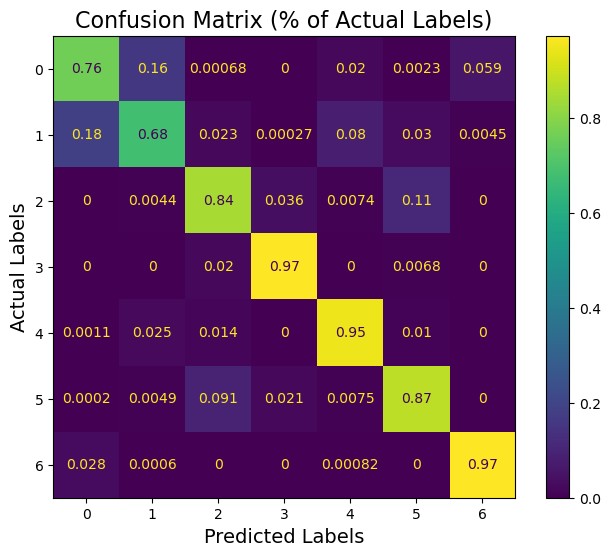

In [26]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. LightGBM (Random Forest)

In [27]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'rf',
        metric = 'multi_logloss',
        colsample_bynode = 0.8,
        subsample = 0.8,
        subsample_freq = 1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 78.81% Accuracy in 2.83s.
Fold 1: 75.952% Accuracy in 2.96s.
Fold 2: 77.302% Accuracy in 2.64s.
Fold 3: 77.857% Accuracy in 2.85s.
Fold 4: 79.603% Accuracy in 2.61s.
Fold 5: 78.333% Accuracy in 2.69s.
Fold 6: 78.73% Accuracy in 2.65s.
Fold 7: 77.857% Accuracy in 2.66s.
Fold 8: 78.254% Accuracy in 2.85s.
Fold 9: 79.286% Accuracy in 2.64s.
Fold 10: 80.0% Accuracy in 2.67s.
Fold 11: 78.872% Accuracy in 2.63s.

Mean Acc (CV): 78.405
ROC AUC  (CV): 0.95781
F1 Score (CV): 0.77917
Submission   : 0.62592
Training Time: 32.66s



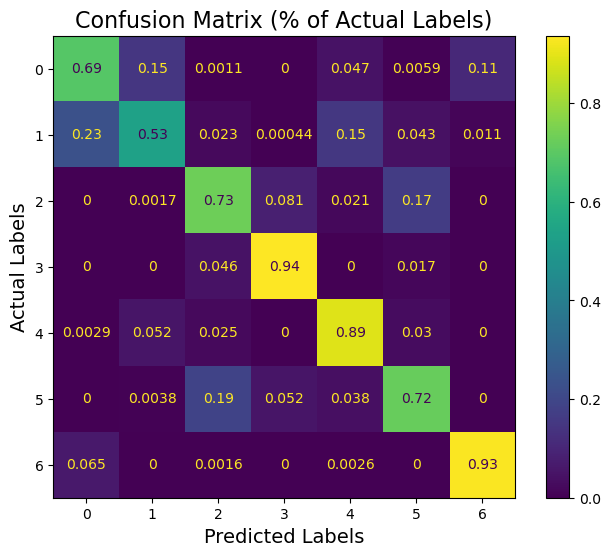

In [28]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. LightGBM (DART)

In [29]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'dart',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 83.81% Accuracy in 3.29s.
Fold 1: 83.413% Accuracy in 3.28s.
Fold 2: 84.286% Accuracy in 3.48s.
Fold 3: 83.651% Accuracy in 3.63s.
Fold 4: 85.635% Accuracy in 4.01s.
Fold 5: 84.603% Accuracy in 3.29s.
Fold 6: 84.206% Accuracy in 3.29s.
Fold 7: 83.651% Accuracy in 3.05s.
Fold 8: 82.619% Accuracy in 3.07s.
Fold 9: 84.683% Accuracy in 3.18s.
Fold 10: 84.127% Accuracy in 3.29s.
Fold 11: 85.068% Accuracy in 2.95s.

Mean Acc (CV): 84.146
ROC AUC  (CV): 0.98078
F1 Score (CV): 0.83811
Submission   : 0.70406
Training Time: 39.83s



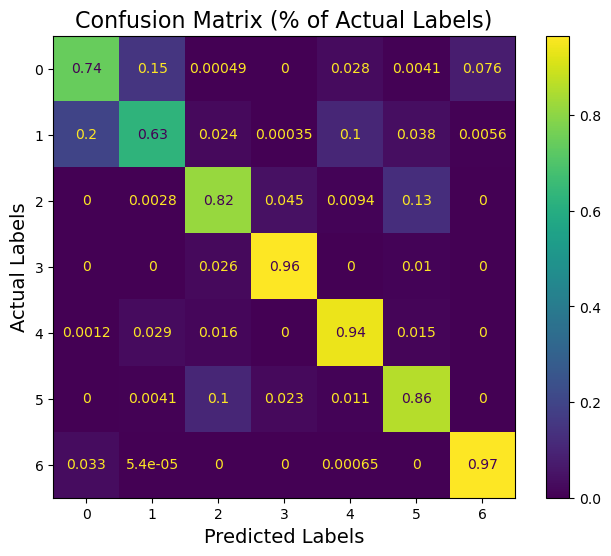

In [30]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. LightGBM (GOSS)

In [31]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'goss',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 85.556% Accuracy in 3.34s.
Fold 1: 84.921% Accuracy in 3.07s.
Fold 2: 85.397% Accuracy in 3.25s.
Fold 3: 87.222% Accuracy in 3.54s.
Fold 4: 87.46% Accuracy in 3.6s.
Fold 5: 84.841% Accuracy in 3.86s.
Fold 6: 86.825% Accuracy in 3.2s.
Fold 7: 85.079% Accuracy in 3.22s.
Fold 8: 83.889% Accuracy in 3.51s.
Fold 9: 87.143% Accuracy in 3.42s.
Fold 10: 85.635% Accuracy in 3.27s.
Fold 11: 86.418% Accuracy in 3.26s.

Mean Acc (CV): 85.866
ROC AUC  (CV): 0.98331
F1 Score (CV): 0.85683
Submission   : 0.74069
Training Time: 40.54s



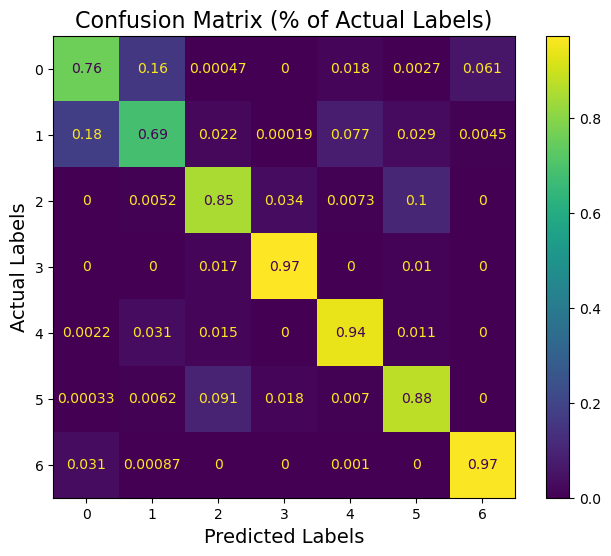

In [32]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_GOSS', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LightGBM (ExtraTrees)

In [33]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        extra_trees = True,
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 83.016% Accuracy in 3.36s.
Fold 1: 81.032% Accuracy in 3.47s.
Fold 2: 81.825% Accuracy in 3.36s.
Fold 3: 82.619% Accuracy in 3.57s.
Fold 4: 82.857% Accuracy in 3.56s.
Fold 5: 83.413% Accuracy in 3.55s.
Fold 6: 81.508% Accuracy in 3.5s.
Fold 7: 81.349% Accuracy in 3.37s.
Fold 8: 81.825% Accuracy in 3.44s.
Fold 9: 81.746% Accuracy in 3.39s.
Fold 10: 83.81% Accuracy in 3.48s.
Fold 11: 83.479% Accuracy in 3.64s.

Mean Acc (CV): 82.37299999999999
ROC AUC  (CV): 0.97868
F1 Score (CV): 0.82095
Submission   : 0.70959
Training Time: 41.68s



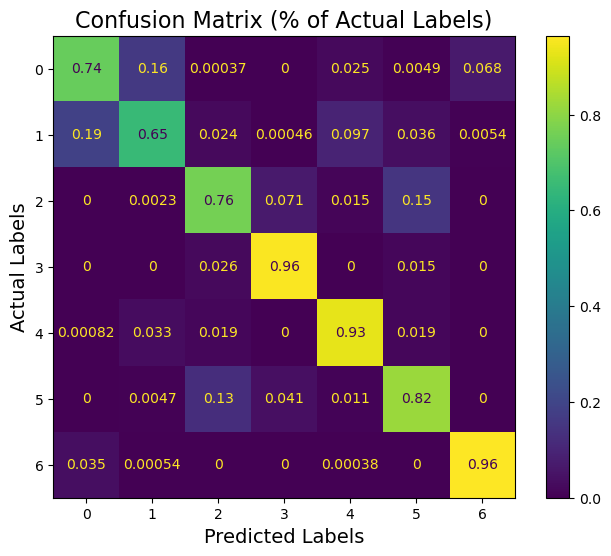

In [34]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_ExtraTrees', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# CatBoost

In [35]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)

Fold 0: 85.952% Accuracy in 11.16s.
Fold 1: 85.476% Accuracy in 11.14s.
Fold 2: 85.476% Accuracy in 11.1s.
Fold 3: 86.587% Accuracy in 12.13s.
Fold 4: 87.302% Accuracy in 11.38s.
Fold 5: 85.0% Accuracy in 10.81s.
Fold 6: 85.079% Accuracy in 10.9s.
Fold 7: 85.556% Accuracy in 10.68s.
Fold 8: 83.81% Accuracy in 10.57s.
Fold 9: 86.905% Accuracy in 11.52s.
Fold 10: 86.19% Accuracy in 10.3s.
Fold 11: 86.338% Accuracy in 10.47s.

Mean Acc (CV): 85.80600000000001
ROC AUC  (CV): 0.98388
F1 Score (CV): 0.85582
Submission   : 0.73626
Training Time: 132.15s



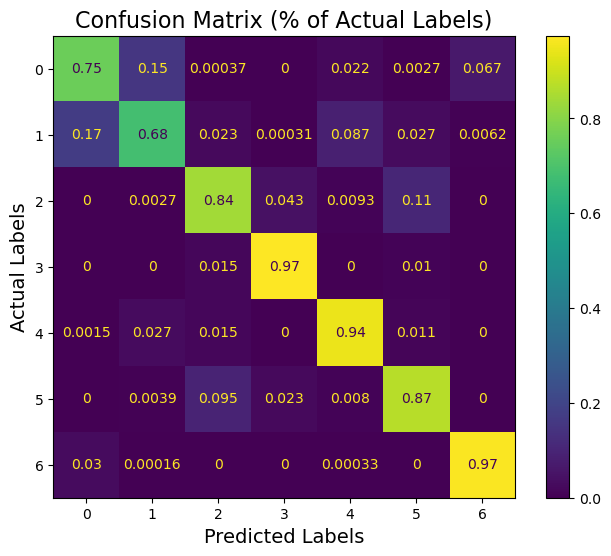

In [36]:
test_score, oof_preds, holdout = train_original(catboost_pipeline)

metrics.append((
    'CatBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Summary

In [37]:
pd.DataFrame.from_records(
    data = metrics,
    columns = ['model','accuracy','holdout','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('holdout', ascending = False).reset_index(drop = True)

,model,accuracy,holdout,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
0,ExtraTrees,0.885377,0.782060,0.796180,0.735681,0.878077,0.977853,0.966862,0.903729,0.974550
1,AdaBoost,0.785965,0.762291,0.793776,0.702313,0.861438,0.964225,0.953907,0.865983,0.970954
2,Bagging,0.850057,0.759820,0.775515,0.709630,0.859622,0.981261,0.962089,0.888867,0.971880
3,RandomForest,0.864542,0.748216,0.774332,0.689768,0.847924,0.972743,0.954589,0.873151,0.969537
4,XGBoost,0.858721,0.741082,0.765004,0.682707,0.845870,0.977853,0.949407,0.872296,0.970681
5,LightGBM_GOSS,0.858655,0.740686,0.758723,0.686421,0.849025,0.972743,0.941497,0.877491,0.966594
6,HistGradientBoost,0.857861,0.740476,0.762882,0.682540,0.845394,0.972743,0.952407,0.880647,0.971717
7,LightGBM,0.857663,0.738069,0.761389,0.679417,0.844352,0.972743,0.948861,0.874729,0.970627
8,CatBoost,0.858060,0.736261,0.754078,0.682245,0.839619,0.974446,0.944225,0.869731,0.969700
9,XGBoost_DART,0.847808,0.723891,0.754955,0.658801,0.827683,0.969336,0.944770,0.857500,0.969319
